In [45]:
from lxml import etree
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import extract as X
import parsing_xml as px

In [58]:
ag = etree.parse('/home/luis/planetmath_defs.xml').getroot()

In [59]:
G = nx.DiGraph()
def_dict = {} #keys: dfndum Value: list of hashes of statements where the is appears
hash_dict = {} # keys: hashe of statements, Values: the text of the statement
for D in ag.iter(tag = 'stmnt'):
    hash_dict[hash(D.text)] = D.text
    
for d in ag.iter(tag = 'dfndum'):
    D = d.getparent().find('stmnt').text
    if d.text.strip() in def_dict:
        def_dict[d.text.strip()].append(hash(D))
    else:
        def_dict[d.text.strip()] = [hash(D),]
print('def_dict has this many elements ', len(def_dict.values()))

def_dict has this many elements  480


In [60]:
dgraph = nx.DiGraph()

In [61]:
empty_str_if_none = lambda s: s if s  else ''
for k,d_raw in enumerate(def_dict.keys()):
    d = d_raw.strip()
    if k%1000 == 0:
        print('doing k=', k)
    for Def in ag.iter(tag = 'definition'):
        D = Def.find('.//stmnt')
        #Check if D is not a definition for d
        if hash(D.text) in def_dict[d]:
            pass
        else:
            dfndum_lst = [c.text for c in D.getparent().findall('.//dfndum') ]
            if d in empty_str_if_none(D.text):
                add_edges_lst = [(d, p.strip()) for p in dfndum_lst if d != p]
                dgraph.add_edges_from(add_edges_lst)

doing k= 0


456

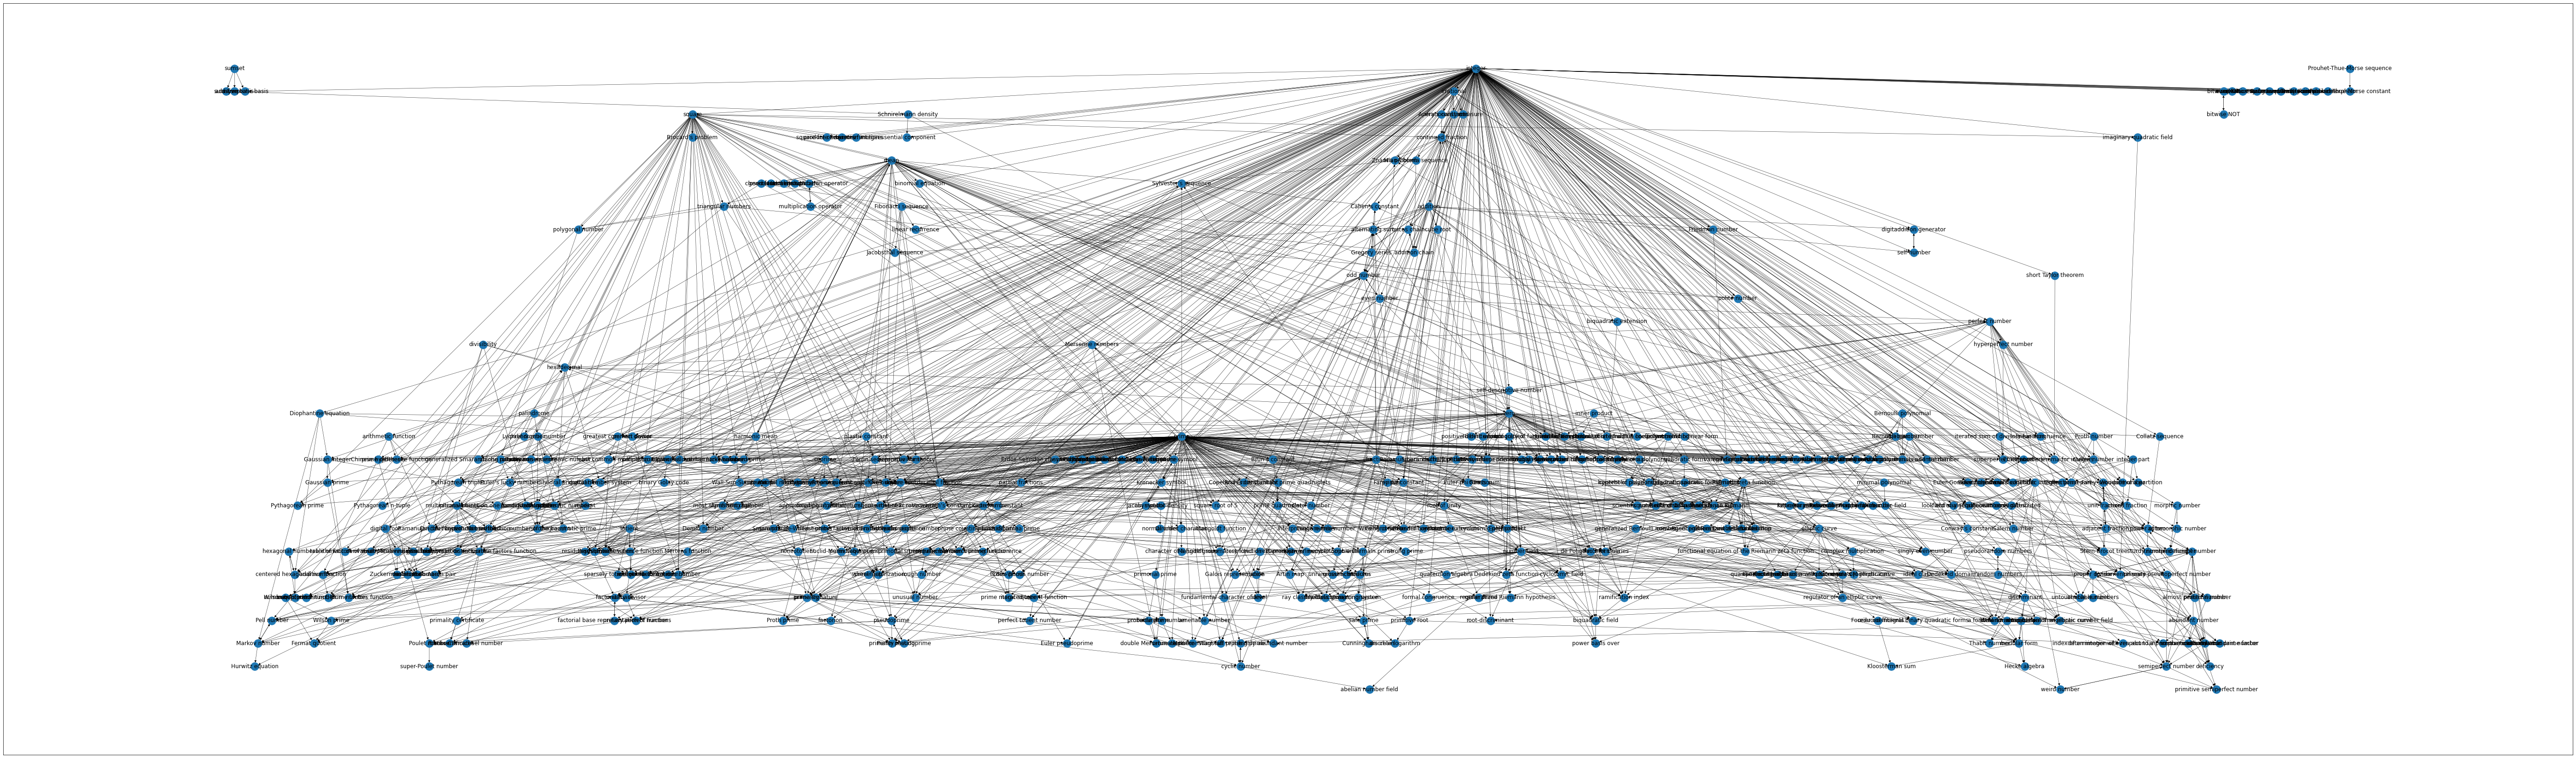

In [53]:
opts = {
    'node_size': 300,
    'width': 0.5,
    'with_labels': True,
}
plt.figure(1, figsize=(100,30))
pos = graphviz_layout(dgraph, prog='dot')
nx.draw_networkx(dgraph, pos, **opts)
#plt.savefig('data/starts_with_p_spectral.png')

In [62]:
nx.ancestors(dgraph, 'Hurwitz equation')

{'Apéry’s constant',
 'Cahen’s constant',
 'Collatz sequence',
 'Diophantine equation',
 'Gregory series',
 'Markov number',
 'Mersenne numbers',
 'Möbius function',
 'Pell number',
 'Sylvester’s sequence',
 'Znám’s problem',
 'abundant number',
 'addition',
 'additive function',
 'algebraic number',
 'almost perfect number',
 'alternating sum',
 'amicable numbers',
 'arithmetic function',
 'closed form',
 'composite number',
 'continued fraction',
 'coprime',
 'deficient number',
 'digital root',
 'divisibility',
 'divisibility test',
 'even number',
 'fraction',
 'geometric mean',
 'greatest common divisor',
 'harmonic mean',
 'hexadecimal',
 'integer',
 'integer factorization',
 'irrational',
 'least prime factor',
 'least significant digit',
 'mean',
 'most significant digit',
 'multiplicative function',
 'number of distinct prime factors function',
 'odd number',
 'perfect number',
 'period',
 'polite number',
 'power of two',
 'primality',
 'prime',
 'probable prime',
 'proper di

In [55]:
cycle_cnt = 0
while True:
    try:
        #cycle_edge = nx.find_cycle(dgraph)[0]
        #dgraph.remove_edge(*cycle_edge)
        cycle_edges = nx.find_cycle(dgraph)
        for c in cycle_edges:
            dgraph.remove_edge(*c)
        #dgraph.add_edge(cycle_edge[1], cycle_edge[0])
        cycle_cnt += 1
    except nx.NetworkXNoCycle:
        print(f'Done!! Reversed {cycle_cnt} cycles')
        break

Done!! Reversed 40 cycles


In [56]:
# Toy Example
#dgraph = nx.DiGraph()                
#dgraph.add_nodes_from([repr(i) for i in range(5)])
#dgraph.add_edges_from([('0','1'),('1','2'),('1','3'),('3','4')])

ranking = LpProblem('NodeRankingProblem', LpMinimize)
l = LpVariable.dict('l', list(dgraph.nodes()), 0)
# Add the objective first
ranking += lpSum([l[w] - l[v] for v,w in dgraph.edges()])
# the constraints
for v,w in dgraph.edges():
    ranking += l[w] - l[v] >= 1
ranking.solve()
ranking.variables()

[l_Achilles_number,
 l_Apéry’s_constant,
 l_Armstrong_number,
 l_Artin_map,
 l_Basel_problem,
 l_Beatty_sequence,
 l_Bernoulli_number,
 l_Bernoulli_periodic_function,
 l_Bernoulli_polynomial,
 l_Bernoulli_polynomials_and_numbers,
 l_Blum_number,
 l_Brocard’s_problem,
 l_Brun’s_constant,
 l_Brun’s_constant_for_prime_quadruplets,
 l_Cahen’s_constant,
 l_Carmichael_function,
 l_Carol_number,
 l_Champernowne’s_constant,
 l_Chebyshev_functions,
 l_Chen_prime,
 l_Chinese_hypothesis,
 l_Collatz_sequence,
 l_Compositorial,
 l_Conway’s_constant,
 l_Copeland_Erdős_constant,
 l_Cullen_number,
 l_Cullen_prime,
 l_Cunningham_chain,
 l_Dedekind_domain,
 l_Dedekind_zeta_function,
 l_Demlo_number,
 l_Diophantine_equation,
 l_Dirichlet_L_series,
 l_Dirichlet_character,
 l_Dirichlet_eta_function,
 l_Dirichlet_hyperbola_method,
 l_Eisenstein_integers,
 l_Eisenstein_prime,
 l_Erdős_Selfridge_classification_of_primes,
 l_Erdős_Woods_number,
 l_Euclid_Mullin_sequence,
 l_Euler_Gompertz_constant,
 l_Euler_nu

In [23]:
list(dgraph.nodes())

[0, 1, 2, 3, 4]

In [73]:
# Least specific term (terms with the most out_degree - in_degree)
node_lst = []
for node in dgraph.nodes():
    deg = dgraph.out_degree(node) - dgraph.in_degree(node)
    node_lst.append((node, deg))
sorted(node_lst, key=lambda d: -d[1])

[('integer', 236),
 ('prime', 223),
 ('square', 55),
 ('zero', 54),
 ('mean', 47),
 ('fraction', 38),
 ('addition', 23),
 ('number field', 21),
 ('Riemann', 18),
 ('perfect number', 18),
 ('least significant digit', 16),
 ('coprime', 16),
 ('irrational', 13),
 ('totient', 11),
 ('period', 11),
 ('algebraic number', 11),
 ('composite number', 10),
 ('even number', 8),
 ('prime counting function', 8),
 ('elliptic curve', 7),
 ('palindromic number', 7),
 ('algebraic integer', 7),
 ('odd number', 6),
 ('multiplicative function', 6),
 ('abundant number', 6),
 ('digital root', 6),
 ('Fibonacci sequence', 6),
 ('minimal polynomial', 6),
 ('continued fraction', 5),
 ('proper divisor', 5),
 ('primality', 5),
 ('divisibility', 5),
 ('greatest common divisor', 5),
 ('Bernoulli number', 4),
 ('palindrome', 4),
 ('number of distinct prime factors function', 4),
 ('semiprime', 4),
 ('repunit', 4),
 ('inner product', 4),
 ('Mersenne numbers', 4),
 ('Diophantine equation', 4),
 ('transcendental number

In [69]:
#Most specific terms (terms with no descendents)
for node in dgraph.nodes():
    if nx.descendants(dgraph, node) == set():
        print(node)
        #print(node.split()[0].lower())

Blum number
surd
Smarandache function
square root of 5
irrationality measure
square root of 3
Liouville number
cyclotomic units
ray class field
Erdős-Woods number
prime signature
ray class group
regulator of an elliptic curve
fundamental units
abelian number field
grössencharacter
canonical height on an elliptic curve
unramified action
root-discriminant
idèle
ideal norm
ideal class
the Grössencharacter associated to a CM elliptic curve
discriminant in algebraic number field
quaternion algebra
power basis over
multiplicative congruence
Pythagorean n-tuple
rational points on one dimensional sphere
tetrahedral number
generalized binomial coefficients
Salem number
Kloosterman sum
super-Poulet number
Hensel’s lemma for integers
asymptotic estimate
Bernoulli polynomials and numbers
Bernoulli periodic function
lucky prime
Euler’s lucky number
Mangoldt summatory function
Lychrel number
generalized Smarandache palindrome
hyperbolic plane in quadratic spaces
diagonal quadratic form
reduced integ

In [63]:
#dgraph.add_node('Term0')
for node in dgraph.nodes():
    if dgraph.in_degree(node) == 0:
        print(node)

lattice in
Bernoulli polynomial
Mangoldt function
palindrome
iterated sum of divisors function
sumset
Prouhet-Thue-Morse sequence
restricted direct product
divisibility
inner product
minimal polynomial
closed form
asymptotic density
Term0


In [64]:
nx.descendants(dgraph, 'minimal polynomial')

{'Salem number',
 'algebraic conjugates',
 'biquadratic field',
 'cyclotomic field',
 'cyclotomic polynomial',
 'discriminant in algebraic number field',
 'field of algebraic numbers',
 'power basis over',
 'pure cubic field',
 'regular prime'}

In [101]:
nx.clustering(dgraph, 'integer')

0.006187285040598518

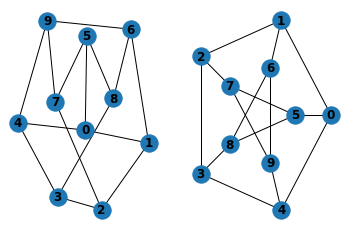

In [12]:
G = nx.petersen_graph()
plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')